In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp
from torch.utils.data import TensorDataset

![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

We have provided an example of a very simple feed forward network that has a strongly vanishing gradient w.r.t. the weights that are increasingly close to the input end. 

Your job is to modify the network so that it uses skip connections and make observations on what happens to the gradient after. 

Text(0, 0.5, 'Weight Gradients')

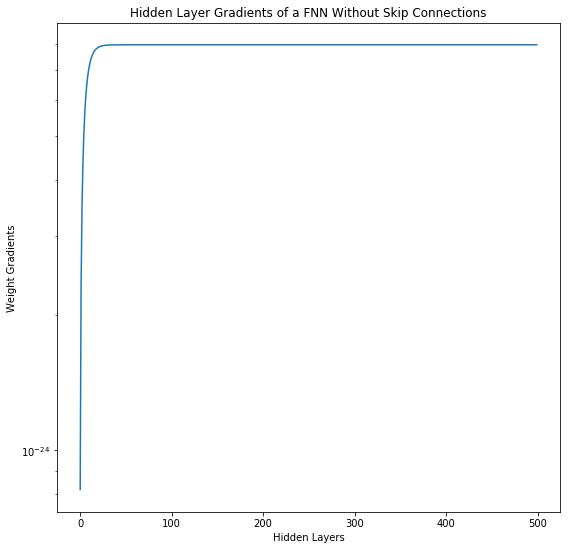

In [6]:
# Choose an activation function
activation = torch.tanh

# Choose a number of iterations
n = 500


# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1.0])

# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([.9],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    #TODO: replace the line below with one that would add a skip connection
    z_i = zprime_i
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward(retain_graph=True)

# Print each weight's gradient
w_grad_init = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad_init.append(grad)
    
plt.semilogy(w_grad_init)
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')

Text(0, 0.5, 'Weight Gradients')

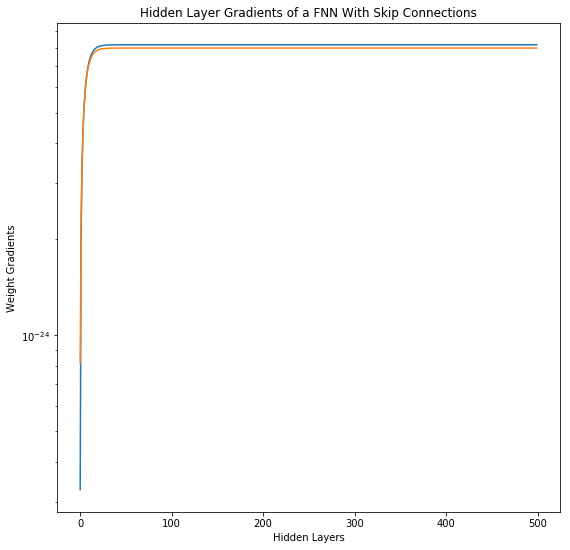

In [7]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
x = torch.randn((1,),requires_grad=True)
z_prev = x
# Loop over a number of hidden layers



#skip1 = #TODO
#skip2 = #TODO  

    
for i in range(1,n+1):
    # New weight
    w_i = torch.tensor([.9],requires_grad=True)
   
    # Linear transform
    a_i = w_i*z_prev 

    # Activation
    zprime_i = activation(a_i) 
    zprime_i.add(z_prev)

    # TODO: replace the line below with one that would add a skip connection
    
    # use the .add(tensor) method
    
    # think about how we would skip multiple layers using MULTIPLE skip lengths in this instance (hint, use branching and the modulus operator)
    
    # We found the results to be VERY non-linear
 
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    a_list.append(a_i)
    # output of layer i becomes input for layer i+1
    z_prev = zprime_i

# Objective function
L = torch.sqrt((zprime_i - z_obs)**2)

# Reverse-mode AD
L.backward(retain_graph=True)

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

#w_grad = sp.savgol_filter(w_grad,5,3)
plt.semilogy(w_grad,label='Skip Connections')
plt.semilogy(w_grad_init,label='No Skip Connections') #compare to previous network
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')


In [8]:
w_list[0].grad

tensor([-3.2747e-25])

Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss difference after 100 iterations, and come up with a justification for that difference in loss

Now we will run an implemenation of a simple deep convolutional network on MNIST (handwritten numbers)

In [9]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_data = train_dataset.data[::20].unsqueeze(1).float()
train_targets = train_dataset.targets[::20].unsqueeze(1)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_data = test_dataset.data[::20].unsqueeze(1).float()
test_targets = test_dataset.targets[::20].unsqueeze(1)

training_data = TensorDataset(train_data,train_targets)
testing_data = TensorDataset(test_data,test_targets)

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=100,
                                          shuffle=False)



This model allows you to input a specified number of convolutional layers in your network.

In [10]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            x = self.linears[i](zprev)
            zi = F.sigmoid(x)
            zprev = zi
    
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [11]:
def train_model(epic, your_net):
        train_accuracy = []
        test_accuracy = []
        
        model = your_net
        model.to(device)

        criterion = torch.nn.CrossEntropyLoss() #since ive set this up as a classification problem with bins number of classes

        optimizer = torch.optim.Adam(model.parameters())

        epochs = epic
        # Loop over the data

        for epoch in range(epochs):
                model.train()
                # Loop over each subset of data

                correct = 0
                total = 0        

                for d,t in train_loader:
                        # Zero out the optimizer's gradient buffer
                        optimizer.zero_grad()
                        # Make a prediction based on the model
                        outputs = model(d)
                        # Compute the loss
                        loss = criterion(outputs,t[:,0])
                        # Use backpropagation to compute the derivative of the loss with respect to the parameters
                        loss.backward()
                        # Use the derivative information to update the parameters
                        optimizer.step()

                        
                        _, predicted = torch.max(outputs.data, 1)
                        correct += len(predicted[predicted==t[:,0]])
                        total += len(predicted.flatten())
                                
                correcttest = 0
                totaltest = 0        

                for d,t in test_loader:
                
                    outputs = model(d)
                    _, predicted = torch.max(outputs.data, 1)
                    correcttest += len(predicted[predicted==t[:,0]])
                    totaltest += len(predicted.flatten())
                
                if epoch%10==0:      
                        print(epoch,loss.item(), ' Train_Accuracy = ', correct/total*100,' Test_Accuracy = ', correcttest/totaltest*100)
                
                train_accuracy.append(correct/total*100)
                test_accuracy.append(correcttest/totaltest*100)
        
        return train_accuracy, test_accuracy

You can mess with these paramenters and see how your model performance changes

In [12]:
num_input_images = 100
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
num_epochs = 50 #how long to run the model
num_layers = 10 #how many convolutions to perform

C:\Users\Tony\Anaconda3\envs\tensorflow_env\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 2.2820563316345215  Train_Accuracy =  9.433333333333334  Test_Accuracy =  9.4
10 2.300017833709717  Train_Accuracy =  11.033333333333333  Test_Accuracy =  11.799999999999999
20 0.8619336485862732  Train_Accuracy =  63.7  Test_Accuracy =  61.8
30 1.0166387557983398  Train_Accuracy =  67.0  Test_Accuracy =  64.2
40 0.8312216401100159  Train_Accuracy =  71.3  Test_Accuracy =  70.19999999999999


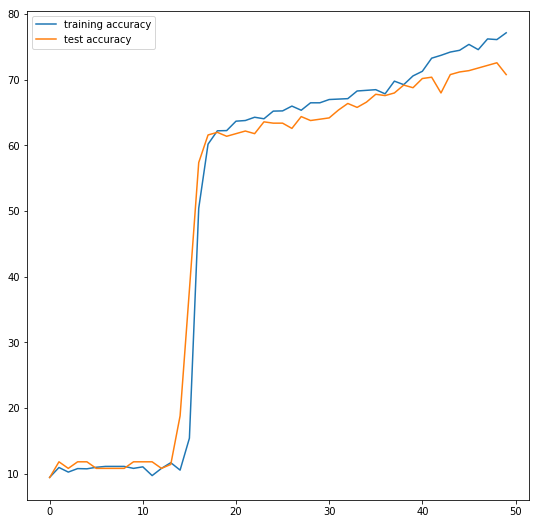

In [13]:
trainacc_init, testacc_init = train_model(num_epochs, Net(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

In a similar fashion to what you did on the previous FNN, add skip connects and see if you can improve the model.

In [16]:
# basic net class
#skip1 = # TODO fill in SKIPS
#skip2 = #


class ResNet(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        #self.linearization1 = nn.Linear(28,28)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
        self.a_list = []
        self.z_list = []
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            #ai = self.linearization(zprev)
          
            ai = self.linears[i](zprev)
            
            # TODO: Implement skip connections in a similar fashion to what was done previously.
            # Think carefully about your skip intervals, and what should be used where
            # hint: use the lists defined as a class object, the modulus operator, and the .add() method
           
            zi = F.sigmoid(ai) + zprev
            zprev = zi
            self.z_list.append(zi)
            self.a_list.append(ai)
            
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


0 8.095459938049316  Train_Accuracy =  65.9  Test_Accuracy =  77.8
10 0.6382400393486023  Train_Accuracy =  94.33333333333334  Test_Accuracy =  83.39999999999999
20 0.15798747539520264  Train_Accuracy =  97.7  Test_Accuracy =  84.39999999999999
30 0.2987133264541626  Train_Accuracy =  98.7  Test_Accuracy =  83.6
40 0.1518917679786682  Train_Accuracy =  97.93333333333332  Test_Accuracy =  83.0


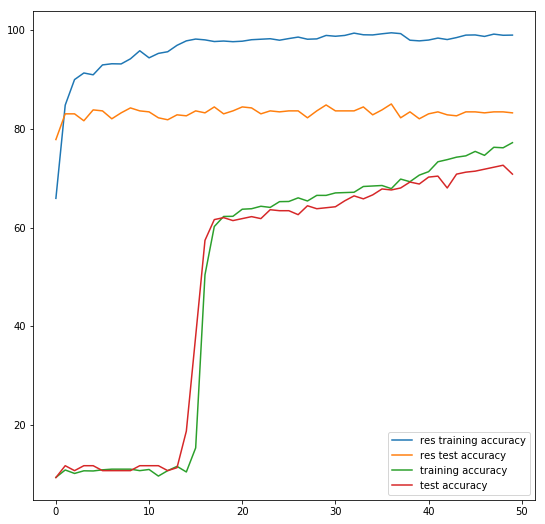

In [17]:
trainaccres_init, testaccres_init = train_model(num_epochs, ResNet(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainaccres_init, label = 'res training accuracy')
plt.plot(testaccres_init, label = 'res test accuracy')
plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?

Vanishing gradient is when the gradient of the error funtion with respect to weights many layers away from the output becomes extremely small. 

2. What are 4 limitations to optimizing a deep convolutional neural network?

Even with residual blocks the amount of layers in the resnet is limited. We are still limited by computaion time. Batch Normalization should help with gradients as well but limits what can be down in parrallel. 

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

My understanding is if the ideal mapping between layers is F(X), without residual connections the blocks would have to learn F directly. With skip connection the block only needs to learn the residual mapping R(X) = F(X)-X. When you add X to R(X) you recover the ideal mapping F. R(X) should be simpler to learn if the F(X) is relatively closs to the identity mapping. 

4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?
How many residual blocks to use and how many layers are in the residual block

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

you allow weights in early parts of the network a shorter path ,through less multiplications and activations, to the output. 

6. Give an appropriate anology for how kernels are used to extract features from images (i.e. sanding wood)

A kernel such as Sobel operator can look for large gradients and thus edge detection.
The anaolgy would be to walk along the image and see where the intensity is decreasing most steeply

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)

I believe this was a good paper and still is a good paper. It demonstrated the effectiveness of their residual technique and changed the game when it comes to deep CNN. Two very good techniques for solving vanishing gradient are bactch normalization and relu activation.  

8. What interval of skip connections did you use and where were they applied to? Did you find any #accuracygainz ?
I used a skip connection of length one. The accuracy wasnt any better but the network did train better.
